### 工作進度  
* 【置頂】**筆記內容架構**與**量化技術分析系統**相關資訊請參閱[251201筆記.ipynb](https://github.com/yilintung/StockInvestmentNotebook/blob/main/251201%E7%AD%86%E8%A8%98.ipynb)之「工作進度」。  

* 引入模組與定義公用函式  

In [1]:
import numpy as np
import mysys
import markdown
from IPython.core.display import HTML

In [2]:
def stock_analysis( analysis, stock_id, buttom_pattern = False) :
    results,images = analysis.analysis(stock_id)
    if buttom_pattern is True and '底部型態' in images :
        print('底型反轉交易策略：')
        display(images['底部型態'])
    print('解盤內容：')
    if '整體評價' in images :
        display(images['整體評價'])
    result_md   = results.to_markdown(tablefmt="grid")
    result_html = markdown.markdown(result_md, extensions=['markdown_grid_tables:GridTableExtension'])
    display(HTML(result_html))

* 更新量化技術分析資料庫  

In [3]:
mysys.UpdatestockDatabase()

2026-01-08 21:18:15.387 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockInfo, data_id: 
2026-01-08 21:18:15.988 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


##### 更新台股總覽 #####
修改股票資訊。代碼 ＝ 3315：股票名稱 ＝ 宣昶，產業類別 ＝ 電子通路業，類型 ＝ twse
修改股票資訊。代碼 ＝ 6239：股票名稱 ＝ 力成，產業類別 ＝ 半導體業，類型 ＝ twse
修改股票資訊。代碼 ＝ 6271：股票名稱 ＝ 同欣電，產業類別 ＝ 半導體業，類型 ＝ twse
修改股票資訊。代碼 ＝ 6446：股票名稱 ＝ 藥華藥，產業類別 ＝ 生技醫療業，類型 ＝ twse
修改股票資訊。代碼 ＝ 6552：股票名稱 ＝ 易華電，產業類別 ＝ 電子工業，類型 ＝ twse
##### 更新技術分析資料 #####
【略過】日Ｋ：2025-12-29
【略過】週Ｋ：2025-12-29


2026-01-08 21:18:25.691 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2025-12-30


2026-01-08 21:18:38.416 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2025-12-31


2026-01-08 21:18:45.826 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-08 21:18:49.975 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2026-01-02


2026-01-08 21:18:56.650 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-08 21:19:00.284 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-08 21:19:03.954 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2026-01-05


2026-01-08 21:19:14.660 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2026-01-06


2026-01-08 21:19:21.317 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【略過】日Ｋ：2026-01-07


2026-01-08 21:19:28.374 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


【新建】日Ｋ：2026-01-08


* 實作選股機制，參考：  
  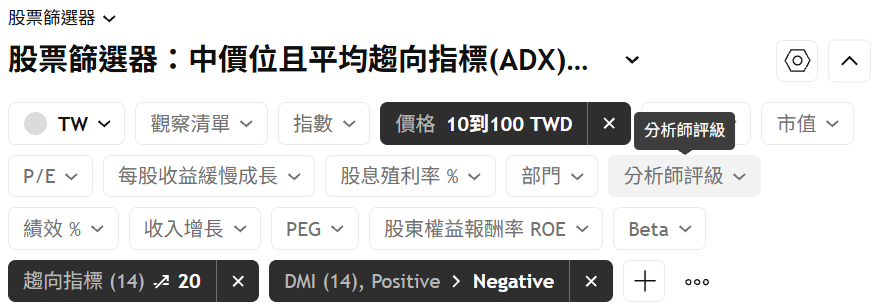  

In [4]:
import os
import pandas as pd
import numpy as np
import datetime
import sqlite3
import time

from talib.abstract import *

In [5]:
# 連線資料庫
conn = sqlite3.connect('data/stock.db')
cursor = conn.cursor()

# 從資料庫中載入「台股總覽 TaiwanStockInfo」
df_stock_info = pd.read_sql("SELECT * FROM StockInfo", conn)

stock_id_list1 = []
# 篩選一 : 保留加權與櫃買個股，並排除排除ETF、ETN、指數、大盤、所有證券與受益證券...等類別之股票
#  追加排除：有英文字的股票
for idx,stock_info in df_stock_info.iterrows() :
    stock_info_id = stock_info['StockID']
    stock_info_type = stock_info['Type']
    stock_info_category = stock_info['IndustryCategory']
    if stock_info_type == 'tpex' or stock_info_type == 'twse' :
        if 'ETF' not in stock_info_category and 'ETN' not in stock_info_category and \
          stock_info_category != 'Index' and stock_info_category != '大盤' and\
          stock_info_category != '所有證券' and stock_info_category != '受益證券' and\
          stock_info_id.isdigit() is True:
            stock_id_list1.append(stock_info_id)

# 設定開始日期與結束日期
current_date       = datetime.datetime.today()
daily_end_date     = current_date.strftime('%Y-%m-%d')
daily_start_date   = current_date - datetime.timedelta(days=240)
daily_start_date   = daily_start_date.strftime('%Y-%m-%d')

# 讀取日Ｋ價格資料
sql_cmd = "SELECT * FROM DailyPrice WHERE Date BETWEEN '{}' AND '{}' ORDER BY Date".format(daily_start_date,daily_end_date)
daily_price_df = pd.read_sql( sql_cmd, conn)

stock_id_list2 = []
# 篩選二 : 保留股價落在10元至100元間的個股
#  追加條件：當日成交量大於500張
for stock_id in stock_id_list1 :
    df_prices = daily_price_df.loc[daily_price_df['StockID'] == stock_id]
    if df_prices.empty is False :
        
        # 成交量格式轉換
        df_prices           = df_prices.drop(columns=['Value'])
        df_prices['Volume'] = df_prices['Volume'].div(1000)
        df_prices['Volume'] = df_prices['Volume'].round()
        
        last_close_price = df_prices.iloc[-1]['Close']
        last_volume      = df_prices.iloc[-1]['Volume']
        if last_close_price > 10.00 and last_close_price < 100.0 and last_volume > 500 :
            stock_id_list2.append(stock_id)

# 篩選三 : ADX指標上升穿越20且+DI > -DI
stock_id_list3 = []
for stock_id in stock_id_list2 :
    df_prices = daily_price_df.loc[daily_price_df['StockID'] == stock_id]
    # 日期格式轉換
    df_prices           = df_prices.drop(columns=['SerialNo','StockID'])
    df_prices['Date']   = df_prices['Date'].astype('datetime64[ns]')
    df_prices.set_index(df_prices['Date'],inplace=True)
    df_prices           = df_prices.drop(columns=['Date'])

    # 成交量格式轉換
    df_prices           = df_prices.drop(columns=['Value'])
    df_prices['Volume'] = df_prices['Volume'].div(1000)
    df_prices['Volume'] = df_prices['Volume'].round()
    
    # 日Ｋ價格資料轉換為talib格式
    df_prices_talib          = df_prices.copy()
    df_prices_talib.columns  = [ i.lower() for i in df_prices_talib.columns]
    
    # 計算ADX指標
    talib_adx = ADX( df_prices_talib, timeperiod=14)
    if talib_adx.iloc[-1] > 20 and talib_adx.iloc[-2] < 20 :
        # 計算+DI與-DI指標
        talib_plus_di = PLUS_DI( df_prices_talib, timeperiod=14)
        talib_minus_di = MINUS_DI( df_prices_talib, timeperiod=14)
        if talib_plus_di.iloc[-1] > talib_minus_di.iloc[-1] :
            stock_id_list3.append(stock_id)
    
# 結果輸出
print('篩選結果：')
for stock_id in stock_id_list3 :
    stock_info = df_stock_info.loc[df_stock_info['StockID'] == stock_id]
    print('股票代碼 ＝ {} ， 股票名稱 ＝ {} '.format(stock_info.iloc[0]['StockID'],stock_info.iloc[0]['StockName']))

# 關閉資料庫
conn.close()

篩選結果：
股票代碼 ＝ 5009 ， 股票名稱 ＝ 榮剛 
股票代碼 ＝ 5014 ， 股票名稱 ＝ 建錩 
股票代碼 ＝ 6016 ， 股票名稱 ＝ 康和證 
股票代碼 ＝ 8374 ， 股票名稱 ＝ 羅昇 
股票代碼 ＝ 1789 ， 股票名稱 ＝ 神隆 
股票代碼 ＝ 1809 ， 股票名稱 ＝ 中釉 
股票代碼 ＝ 3051 ， 股票名稱 ＝ 力特 


* 建立「解盤」物件    

In [6]:
analysis = mysys.StockAnalysis()

### 大盤解盤  

* 加權指數  

> **盤後**：量化技術分析  

解盤內容：


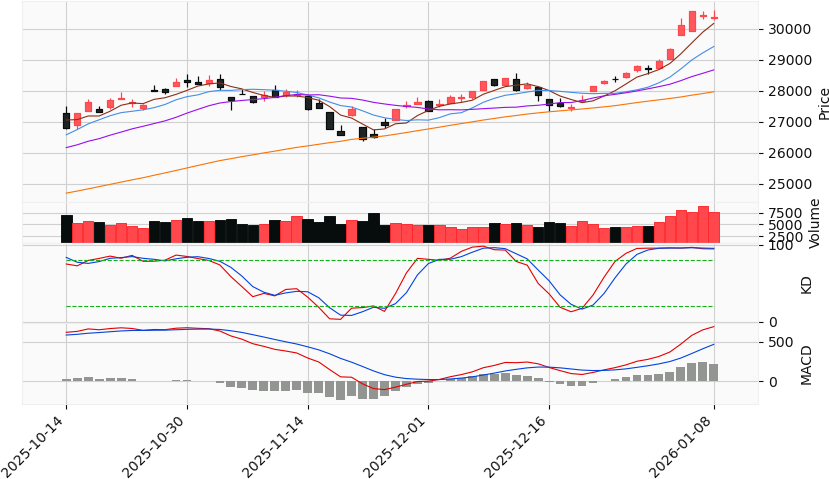

技術分析工具,解盤內容
Ｋ線／Ｋ棒,"紡錘線 : 2026-01-07 , 2026-01-08 十字線 : 2026-01-07 , 2026-01-08 孕育線／懷抱線 : 2026-01-07"
Ｋ線圖,中期為高位階 長期為高位階
成交量,價量關係：未至大量門檻（成交量 ＝ 7592.71億元 ，十日均量 ＝ 6245.24億元）
型態,反轉型態之三重頂，型態範圍由2025-06-23開始到2026-01-08結束，估算目標價為25597.56點。 底型反轉之底部型態，型態範圍由2025-04-02開始到2025-05-02結束，2025-06-10時已達估算之目標價（22257.56點）。
移動平均線,5日線上揚、10日線上揚，短期翻多；20日線上揚、60日線上揚，中期翻多；120日線上揚、240日線上揚，長期翻多
ＫＤ指標,於2026-01-07死亡交叉。並且2026-01-08於超買區。
ＭＡＣＤ指標,MACD在零軸以上，中期多方
週Ｋ－週ＫＤ指標,於2025-12-01當週黃金交叉。
整體評價,"價格趨勢 目前為上漲格局，近期連續走高並站穩短中期均線之上，價格維持強勢推升。近兩日高檔出現小幅震盪與回檔，但尚未破壞上升結構。 價量關係 上漲段成交量明顯放大，屬於價漲量增，多方動能充足。最新一日收黑且量能較前一日縮，偏向高檔震盪中的換手，需留意後續是否出現量縮續強或量增回檔的變化。 支撐與壓力 支撐先看 30,165點（短期均線附近），再看 30,268～30,306點（近一日低點區），跌破則回測 29,424點（次一層短期均線）機率上升。壓力落在 30,593點（近期高點），若帶量突破，將轉為短線續攻的關鍵確認。 KD 指標解讀 K與D長時間位於80以上超買區，且目前高檔鈍化，代表多方仍掌控但追價風險提高。短線若K值持續走低並向下貼近D值，較容易引發高檔回檔整理。 MACD 指標解讀 DIF與MACD線維持正值且同步上行，多方趨勢延續。灰色柱狀體仍在擴張區間但最新一日略有收斂，顯示上攻動能仍強但短線有降溫跡象。 綜合評價 整體偏多，屬於強勢上漲後的高檔震盪，趨勢未轉弱但短線容易出現回檔。操作上以 30,165點／30,268點一帶支撐是否守穩作為續強與否的觀察重點，若失守則需提高停損/降槓桿的紀律；若能放量突破 30,593點，則偏向續攻格局。"


In [7]:
# 盤後：加權指數解盤
stock_analysis(analysis,'TAIEX')

* 櫃買指數  

> **盤後**：量化技術分析  

解盤內容：


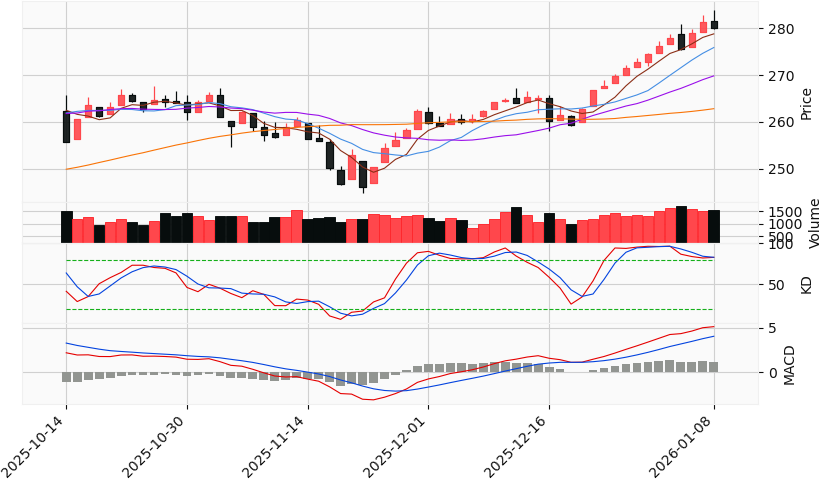

技術分析工具,解盤內容
Ｋ線／Ｋ棒,吞噬 : 2026-01-05
Ｋ線圖,中期為高位階 長期為高位階
成交量,價量關係：未至大量門檻（成交量 ＝ 1551.8億元 ，十日均量 ＝ 1486.48億元）
型態,底型反轉之底部型態，型態範圍由2025-04-02開始到2025-05-02結束，2025-08-18時已達估算之目標價（247.79點）。
移動平均線,5日線上揚、10日線上揚，短期翻多；20日線上揚、60日線上揚，中期翻多；120日線上揚、240日線上揚，長期翻多
ＫＤ指標,於2026-01-05死亡交叉。並且2026-01-08於超買區。
ＭＡＣＤ指標,MACD在零軸以上，中期多方
週Ｋ－週ＫＤ指標,於2025-11-24當週黃金交叉。並且2025-12-29該週在超買區。
整體評價,價格趨勢 整體為上漲格局，近期K線沿短期均線上方推進並創波段高後出現小幅回檔。短中期均線呈多頭排列（5日、10日、20日皆上彎且位於60日線之上），趨勢仍偏多。 價量關係 上漲段量能大致維持中高水位，未見明顯爆量長黑破壞結構，屬「價漲量穩」偏多型態。惟近一日收黑且量能未明顯放大，較像高檔震盪中的整理，而非轉空訊號。 支撐與壓力 上方壓力先看283.91點（近期高點），若突破後才有機會延伸上行空間。下方支撐依序看279.91點（近日低點附近）與278.83點（5日線附近），再下來為275.90點（10日線附近），跌破則回檔壓力將加重。 KD指標解讀 KD位於80以上超買區附近，且K、D數值貼近，顯示高檔動能仍在但追價力道轉為鈍化。若後續K線跌破D線並同步下彎，較容易引發短線回檔加深。 MACD指標解讀 DIF在MACD線之上且兩者皆上行，趨勢動能仍偏多延續。惟OSC柱狀體雖維持正值但略有縮小，代表上攻動能有降溫跡象，短線可能以高檔整理取代急漲。 綜合評價 目前屬多頭趨勢中的高檔整理：均線結構偏多、MACD維持正向，但KD處超買區且動能邊際降溫，短線較易震盪回檔。操作上可重點觀察279.91點/278.83點支撐是否守穩，以及283.91點能否有效突破來確認續攻力道。


In [8]:
# 盤後：櫃買指數解盤
stock_analysis(analysis,'TPEx')

### 個股觀察  

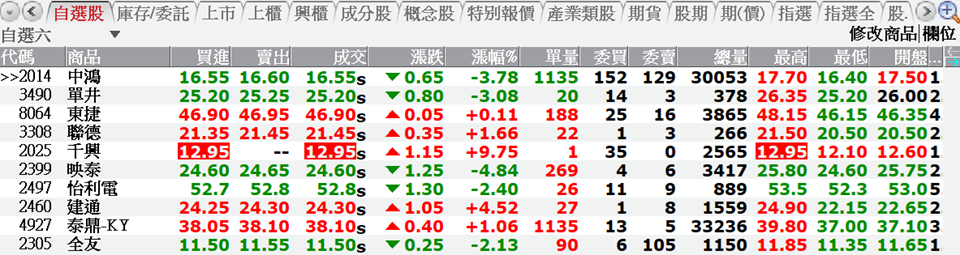  

* 建碁(3046)  
  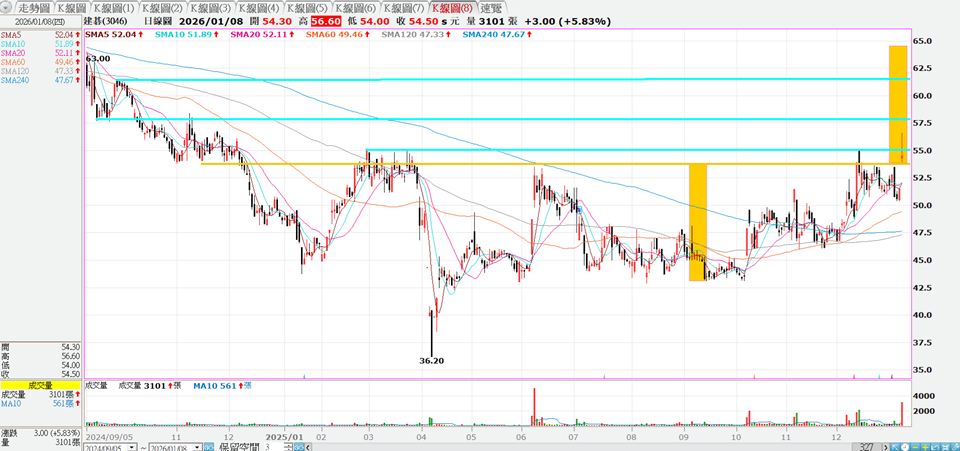  
* 聯電(2303)  
  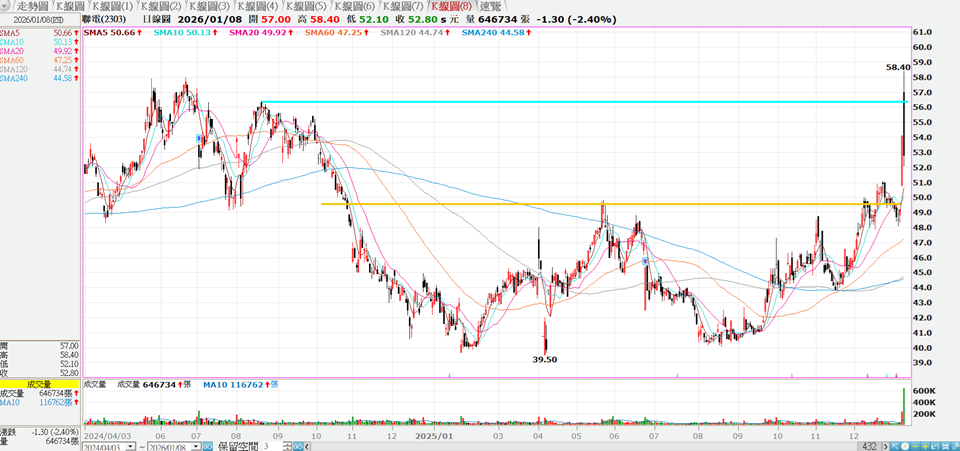  
* 千興(2025)  
  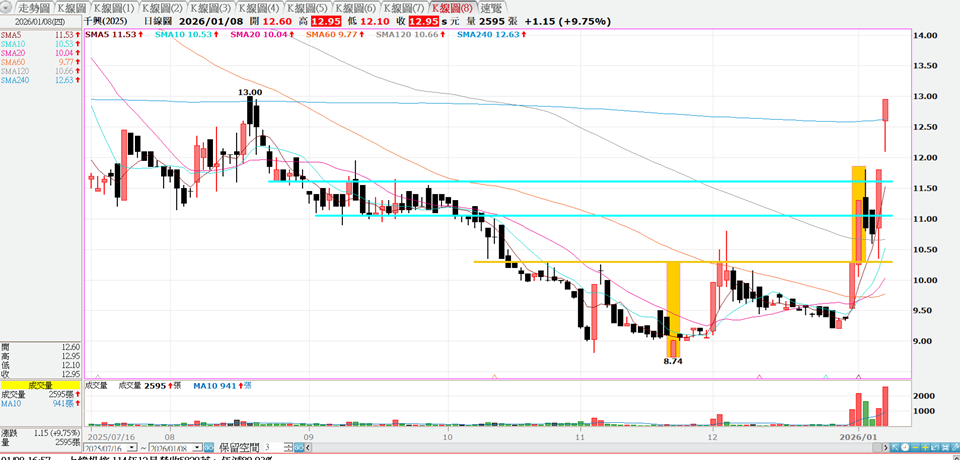  
* 友達(2409)  
  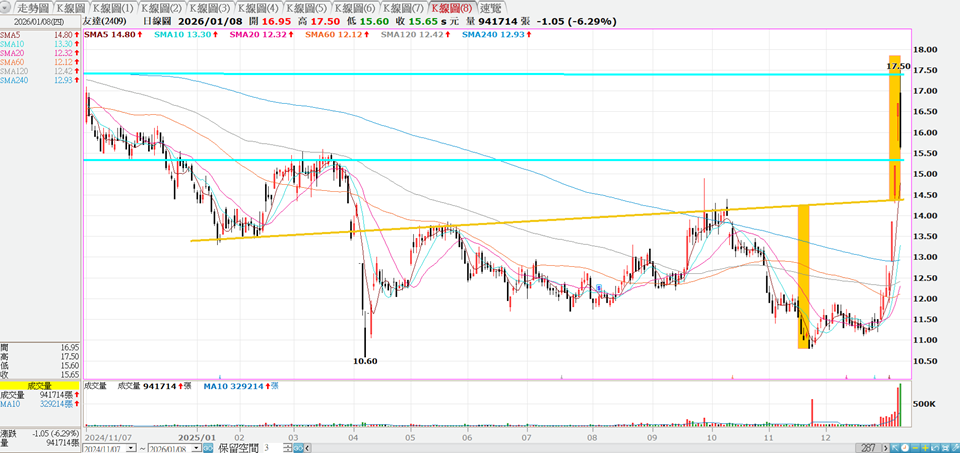    
* 中鴻(2014)  
  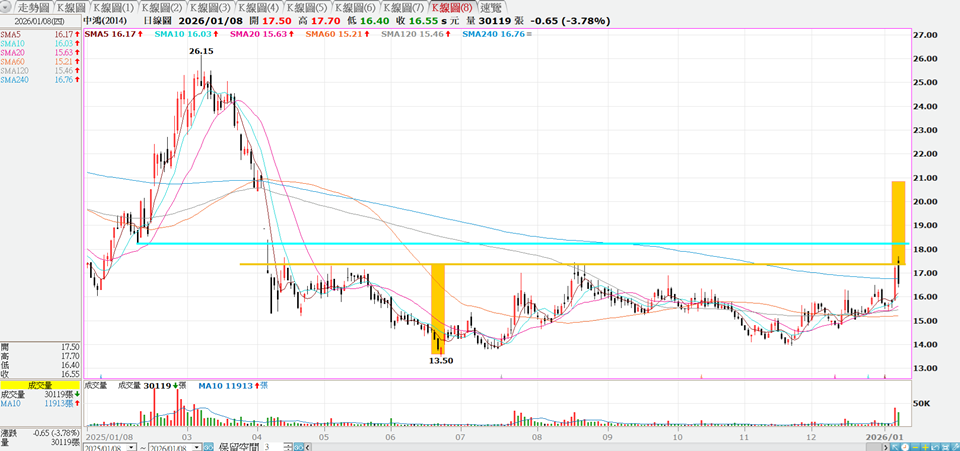  
* 泰鼎-KY(4927)  
  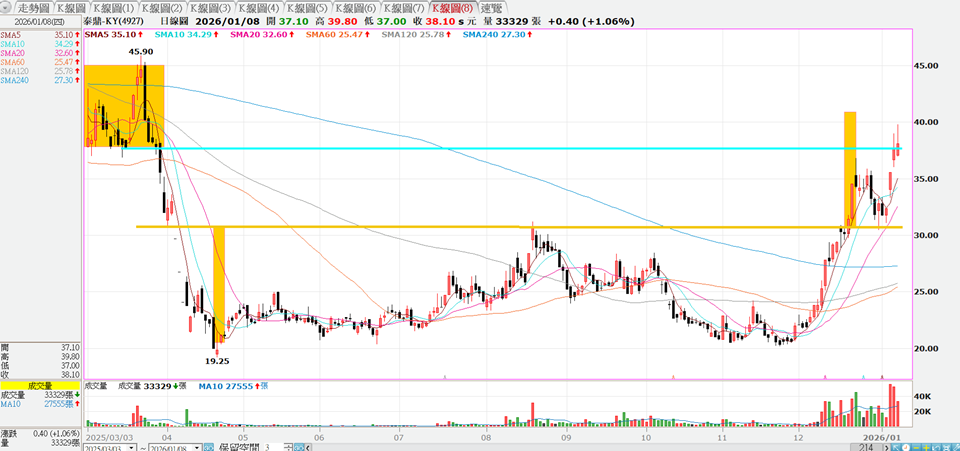    
* 利機(3444)  
  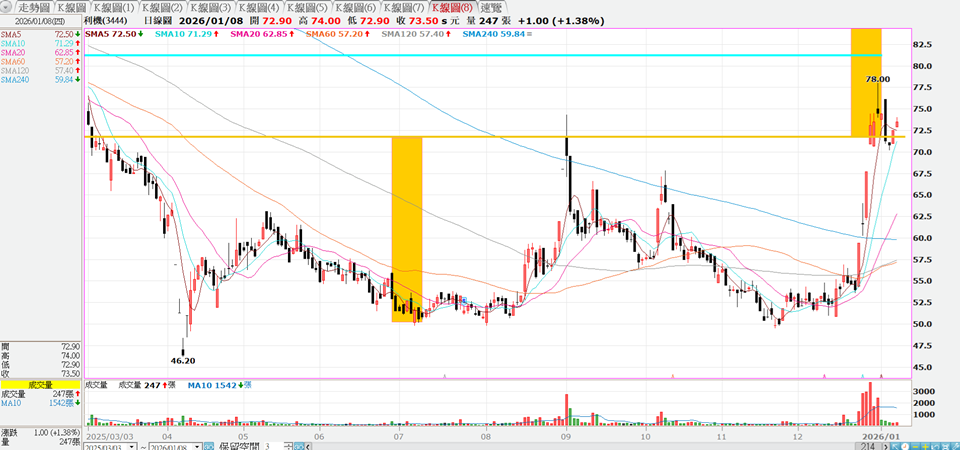    

### 個股解盤  

* 千興(2025)  
  看法：以到底型漲幅目標價，超漲並站上年線。  

> **盤後**：量化技術分析  

底型反轉交易策略：


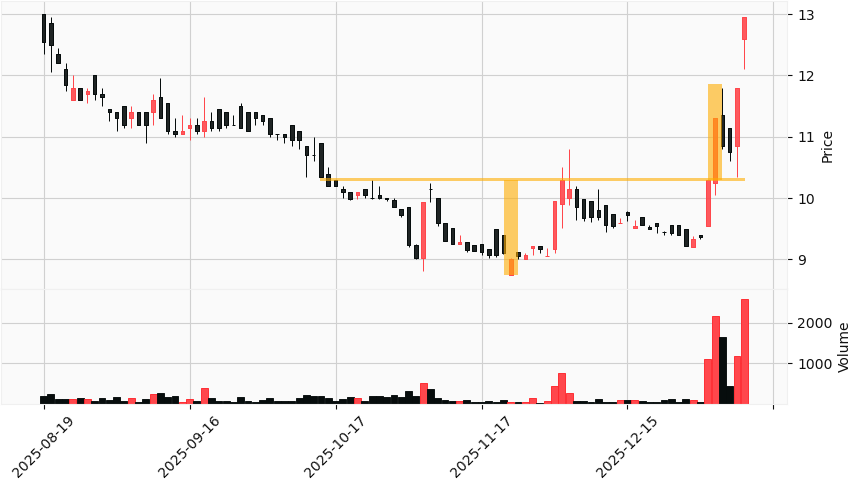

解盤內容：


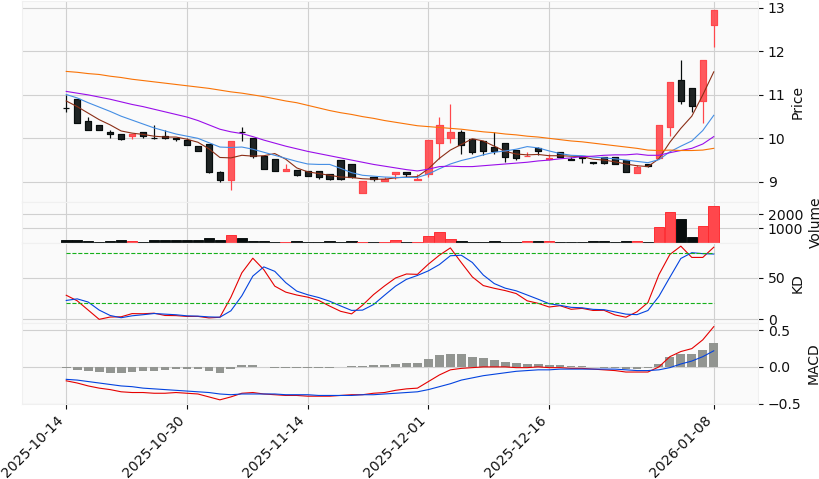

技術分析工具,解盤內容
Ｋ線／Ｋ棒,鎚子線／吊人線 : 2026-01-08
Ｋ線圖,中期為高位階 長期為中位階
成交量,價量關係：大型股天量（成交量 ＝ 2595張 ，十日均量 ＝ 941張）
型態,中繼型態之下降旗形，型態範圍由2025-02-21開始到2025-08-19結束。 底型反轉之底部型態，型態範圍由2025-10-15開始到2026-01-08結束，估算目標價為11.86元。
移動平均線,5日線上揚、10日線上揚，短期翻多；20日線上揚、60日線上揚，中期翻多；120日線上揚、240日線上揚，長期翻多
ＫＤ指標,於2026-01-08黃金交叉。
ＭＡＣＤ指標,MACD在零軸以上，中期多方
週Ｋ－週ＫＤ指標,於2025-12-29當週黃金交叉。
整體評價,價格趨勢 目前為上漲格局，近兩日連續紅K並以12.95元收在波段高位，短線動能明顯轉強。價格已明確站上短中期均線帶，呈現多方主導。 價量關係 上漲同時成交量放大，最新一日量能明顯高於前幾日，屬於價漲量增的偏多訊號。惟短線急拉後若後續量能無法延續，容易出現高檔震盪或回檔測試支撐。 支撐與壓力 支撐先看12.10元（當日低點附近），跌破則看11.80元（前一日收盤/近期高點轉支撐）與11.53元（5日線附近）。壓力以12.95元（當日高點/收盤）為近端關卡，若帶量突破則上方壓力尚未形成。 KD指標解讀 K值位於80以上、D值亦在高檔，屬於偏超買區，短線追價風險上升。K值上彎且仍高於D值，代表多方仍強，但需留意高檔鈍化後的回檔。 MACD指標解讀 DIF線位於MACD線上方且雙線同步上行，顯示趨勢偏多延續。灰色柱狀體持續放大，代表上漲動能正在增強，短線仍有續攻條件。 綜合評價 整體為多方強勢，價漲量增且均線翻多，動能指標同步偏多，有利延續上攻。惟KD進入高檔超買，建議以12.10元/11.80元作為短線回檔觀察與停損依據，若量能續強則偏向續抱或逢回分批布局。


In [9]:
stock_analysis(analysis,'2025',buttom_pattern = True)

> **盤後**：底部反轉交易策略分析  

In [10]:
def line_drawing_callback( range_prices) :
    # 設定頸線
    neckline_start_date = '2025-10-15'
    neckline_end_date   = range_prices.iloc[-1].name.strftime("%Y-%m-%d")
    neckline_price      = range_prices.loc['2025-12-02']['Close']

    # 設定底部日期與價格
    bottom_date  = '2025-11-21'
    bottom_price = range_prices.loc['2025-11-21']['Open']

    # 估算目標價
    target_price = (neckline_price - bottom_price) + neckline_price

    print('估算目標價為{:.2f}元'.format(target_price))

    # 設定突破日期
    breakout_date = '2026-01-02'
    
    seq_of_seq_of_points=[
        [(neckline_start_date,neckline_price),(neckline_end_date,neckline_price)],
        [(bottom_date,bottom_price),(bottom_date,neckline_price)],
        [(breakout_date,neckline_price),(breakout_date,target_price)]
    ]

    linewidths=[2.0,15.0,15.0]
    
    colors=['xkcd:orange yellow','xkcd:orange yellow','xkcd:orange yellow']

    return seq_of_seq_of_points,linewidths,colors

估算目標價為11.86元


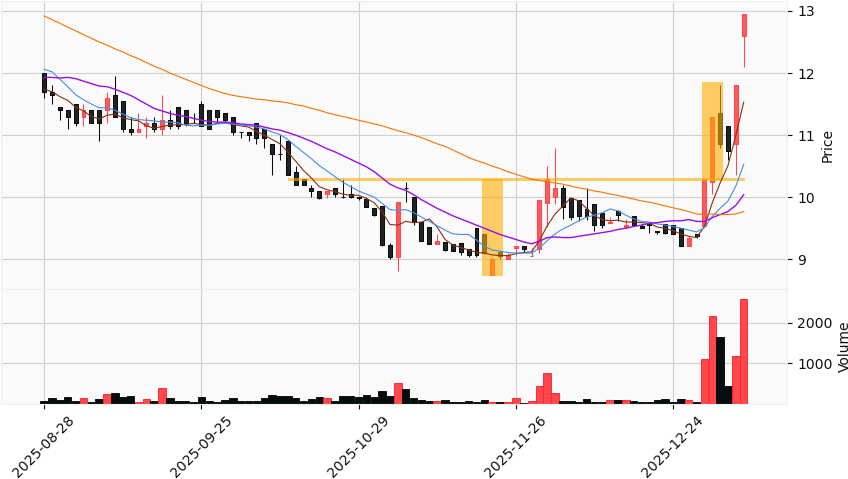

In [11]:
image = mysys.DrawOnKlineChart('2025','2025-08-28','2026-01-08',line_drawing_callback)
display(image)

籌碼面：  
法人小買(+60)：外資小賣(-39)、投信中立(0)、自營小買(+99)。  
主力小買(+115)。  
分公司買賣家數差集中(+8)。  
融資中立(0)、融券中立(0)。  